In [24]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


# Preprocessing

cari cari aja gimana kira kira nge processing data ini, mungkin kayak :
- deteksi outlier
- normalisasi
- encoding
- dll

# Feature Engineering

cari aja eksperimen yg bisa kira kira di terapin, mungkin kayak :

- interaksi feature
- pca component
- polynomial feature
- tranformasi
- dll

# Data Preparation

In [25]:
def load_data():
    data_dir = 'input/'

    df = pd.read_csv(data_dir + 'climate_change_impact.csv')
    return df

In [26]:
df = load_data()

In [27]:
df

,Year,Country,Region,Crop_Type,Average_Temperature_C,Total_Precipitation_mm,CO2_Emissions_MT,Crop_Yield_MT_per_HA,Extreme_Weather_Events,Irrigation_Access_%,Pesticide_Use_KG_per_HA,Fertilizer_Use_KG_per_HA,Soil_Health_Index,Adaptation_Strategies,Economic_Impact_Million_USD
0,2001,India,West Bengal,Corn,1.55,447.06,15.22,1.737,8,14.54,10.08,14.78,83.25,Water Management,808.13
1,2024,China,North,Corn,3.23,2913.57,29.82,1.737,8,11.05,33.06,23.25,54.02,Crop Rotation,616.22
2,2001,France,Ile-de-France,Wheat,21.11,1301.74,25.75,1.719,5,84.42,27.41,65.53,67.78,Water Management,796.96
3,2001,Canada,Prairies,Coffee,27.85,1154.36,13.91,3.890,5,94.06,14.38,87.58,91.39,No Adaptation,790.32
4,1998,India,Tamil Nadu,Sugarcane,2.19,1627.48,11.81,1.080,9,95.75,44.35,88.08,49.61,Crop Rotation,401.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2022,France,Nouvelle-Aquitaine,Cotton,30.48,685.93,17.64,3.033,9,27.56,41.96,10.95,43.41,No Adaptation,1483.06
9996,1999,Australia,Queensland,Soybeans,9.53,2560.38,10.68,2.560,4,77.02,5.45,82.32,59.39,No Adaptation,829.61
9997,2000,Argentina,Patagonia,Coffee,31.92,357.76,26.01,1.161,10,78.53,11.94,26.00,41.46,Water Management,155.99
9998,1996,Brazil,Southeast,Soybeans,13.95,1549.52,17.31,3.348,2,42.65,44.71,25.07,75.10,Crop Rotation,1613.90


In [28]:
X = df.drop(['Economic_Impact_Million_USD'], axis=1)
y = df['Economic_Impact_Million_USD']

In [29]:
X = pd.get_dummies(X, drop_first=True)

In [30]:
X

,Year,Average_Temperature_C,Total_Precipitation_mm,CO2_Emissions_MT,Crop_Yield_MT_per_HA,Extreme_Weather_Events,Irrigation_Access_%,Pesticide_Use_KG_per_HA,Fertilizer_Use_KG_per_HA,Soil_Health_Index,...,Crop_Type_Fruits,Crop_Type_Rice,Crop_Type_Soybeans,Crop_Type_Sugarcane,Crop_Type_Vegetables,Crop_Type_Wheat,Adaptation_Strategies_Drought-resistant Crops,Adaptation_Strategies_No Adaptation,Adaptation_Strategies_Organic Farming,Adaptation_Strategies_Water Management
0,2001,1.55,447.06,15.22,1.737,8,14.54,10.08,14.78,83.25,...,False,False,False,False,False,False,False,False,False,True
1,2024,3.23,2913.57,29.82,1.737,8,11.05,33.06,23.25,54.02,...,False,False,False,False,False,False,False,False,False,False
2,2001,21.11,1301.74,25.75,1.719,5,84.42,27.41,65.53,67.78,...,False,False,False,False,False,True,False,False,False,True
3,2001,27.85,1154.36,13.91,3.890,5,94.06,14.38,87.58,91.39,...,False,False,False,False,False,False,False,True,False,False
4,1998,2.19,1627.48,11.81,1.080,9,95.75,44.35,88.08,49.61,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2022,30.48,685.93,17.64,3.033,9,27.56,41.96,10.95,43.41,...,False,False,False,False,False,False,False,True,False,False
9996,1999,9.53,2560.38,10.68,2.560,4,77.02,5.45,82.32,59.39,...,False,False,True,False,False,False,False,True,False,False
9997,2000,31.92,357.76,26.01,1.161,10,78.53,11.94,26.00,41.46,...,False,False,False,False,False,False,False,False,False,True
9998,1996,13.95,1549.52,17.31,3.348,2,42.65,44.71,25.07,75.10,...,False,False,True,False,False,False,False,False,False,False


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Evaluation

In [32]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [33]:
y_pred = model.predict(X_test)
print('MSE:', mean_squared_error(y_test, y_pred))
print('R2 Score:', r2_score(y_test, y_pred))

MSE: 82151.51063997233
R2 Score: 0.5445419374985231


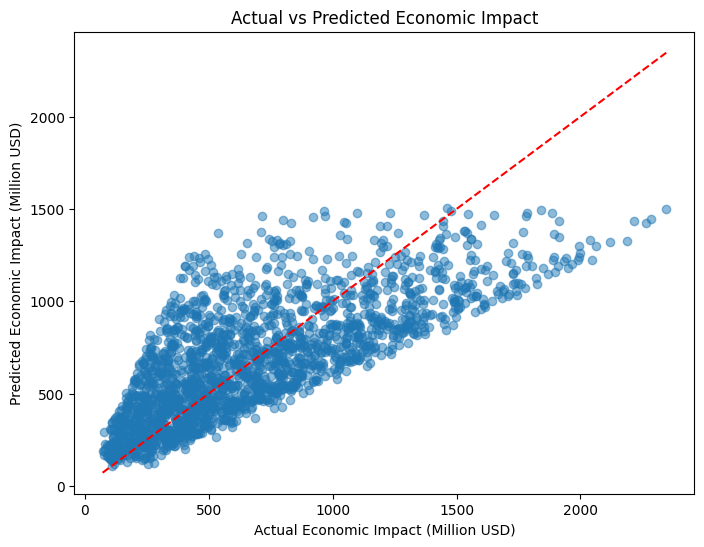

In [34]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Economic Impact (Million USD)')
plt.ylabel('Predicted Economic Impact (Million USD)')
plt.title('Actual vs Predicted Economic Impact')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Garis y=x
plt.show()